In [8]:
# ===== 1. Read Images from HDF5
import numpy as np
import time
import h5py
import keras
import cv2
import matplotlib.pyplot as plt
from keras.models import Model, Sequential, model_from_json, load_model
from keras.applications import vgg16, vgg19, resnet50
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Input, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from math import ceil

DATASET_FILE = 'dataset.h5'
DATASET_FILE_MINI = 'dataset_mini.h5'
DATASET_IMAGES = 'images'
DATASET_LABELS = 'labels'
IMAGE_DIMENSION = 224
IMAGE_INPUT_SHAPE = (IMAGE_DIMENSION, IMAGE_DIMENSION, 3)
LABEL_CLASS = { 'NORMAL': 0, 'CNV': 1, 'DME': 2, 'DRUSEN': 3 }
NUM_CLASSES = len(LABEL_CLASS)
NUM_BATCH_SIZE_BASE = 128 # Larger = more memory
NUM_BATCH_SIZE_VGG16 = 128
NUM_BATCH_SIZE_RESNET = 32 # Smaller = better = longer?
NUM_EPOCHS = 100 # How many times to train (more training = more time).
NUM_DEPTH = 29
MODEL_NAME_BASE = 'model_base.h5'
MODEL_NAME_VGG16 = 'model_vgg16.h5'
MODEL_NAME_RESNET = 'model_resnet.h5'

# Utils
start_time = time.time()
def watch_restart():
    global start_time
    start_time = time.time()
def watch_print(title):
    global start_time
    print(title, (time.time() - start_time), 'seconds')
def get_label(src):
    global LABEL_CLASS
    for key, value in LABEL_CLASS.items():
        if value == src:
            return key
        
# Learning Rate
def lr_schedule(epochs):
    lr = 1e-3
    if epochs > 180:
        lr *= 0.5e-3
    elif epochs > 160:
        lr *= 1e-3
    elif epochs > 120:
        lr *= 1e-2
    elif epochs > 80:
        lr *= 1e-1
    return lr

# Callbacks for model saving and for learning rate adjustment.
# Training should be stopped when val_acc (validation accuracy) stops increasing to prevent overfitting.
checkpoint_base = ModelCheckpoint(filepath=MODEL_NAME_BASE, monitor='val_acc', verbose=1, save_best_only=True)
checkpoint_vgg16 = ModelCheckpoint(filepath=MODEL_NAME_VGG16, monitor='val_acc', verbose=1, save_best_only=True)
checkpoint_resnet = ModelCheckpoint(filepath=MODEL_NAME_RESNET, monitor='val_acc', verbose=1, save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopping_base = EarlyStopping(monitor='val_acc', patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1)

# Use MINI with 1000 images since it takes a long time.
hf = h5py.File(DATASET_FILE_MINI, 'r')
images = np.array(hf[DATASET_IMAGES]).astype('uint8')
labels = np.array(hf[DATASET_LABELS]).astype('uint8')
hf.close()

watch_print('Read Images from HDF5')

Read Images from HDF5 3.030883312225342 seconds


In [2]:
watch_restart()

# ===== 2. Prepare Data

# Normalize input data.
# Neural Networks work best when input data are between 0 and 1 (Instead of 0 to 255).
X = images.astype("float32")
X = X / 255
print("Images Shape", X.shape)

y = labels
print("Labels Shape", y.shape)

# Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Adjust with imbalanced class frequency
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Adjust labels
# Neural Networks will have as many number of outputs as the number of classes.
Y_trainRosHot = np_utils.to_categorical(Y_trainRos, num_classes = 4)
Y_testRosHot = np_utils.to_categorical(Y_testRos, num_classes = 4)

# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = IMAGE_DIMENSION,IMAGE_DIMENSION,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = IMAGE_DIMENSION,IMAGE_DIMENSION,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)

# Shuffle data to permit further subsampling
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

X_train = X_trainRosReshaped
y_train = Y_trainRosHot
X_test = X_testRosReshaped
y_test = Y_testRosHot

print("X_train Shape", X_train.shape)
print("y_train Shape", y_train.shape)
print("X_test Shape", X_test.shape)
print("y_test Shape", y_test.shape)

# Get Class Weights for class frequency.
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("Weights", class_weights)

watch_print('Prepare Data')

Images Shape (10000, 224, 224, 3)
Labels Shape (10000,)
X_train Shape (3068, 224, 224, 3)
y_train Shape (3068, 4)
X_test Shape (1008, 224, 224, 3)
y_test Shape (1008, 4)
Weights [1. 1. 1. 1.]
Prepare Data 16.18506145477295 seconds


In [10]:
watch_restart()

# ===== 3. Create Model Baseline
def get_model_base(input_shape, num_classes):
    ret = Sequential()
    
    # Convolutional Layers:
    # Do Convolutional Layers before Dense Layers to find patterns throughout the image first.
    # Conv2D: 2D since it is an image.
    # 64 Filters: Number of patterns to search for. 
    # (3, 3): Size of the image tiles that look for a pattern for each image.
    # Padding: Pad zeros for image tiles at the edges to be (3, 3).
    ret.add(Conv2D(64,
                   (3, 3),
                   padding="same",
                   activation="relu", 
                   input_shape=input_shape))
    ret.add(Conv2D(64, (3, 3), activation="relu"))

    # Max Pooling
    # Scale down by dividing up the image into (2, 2) and only taking the largest (most important) value.
    ret.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    # Dropout usually after MaxPooling Layer to cut connection between layers to force more learning.
    ret.add(Dropout(0.50))

    # Add another Convolutional Block
    ret.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    ret.add(Conv2D(64, (3, 3), activation="relu"))
    ret.add(MaxPooling2D(pool_size=(2, 2)))
    ret.add(Dropout(0.50))

    # Flatten Layer to transition from Convolutional Layers (2D) to Dense Layers
    ret.add(Flatten())

    # Dense Layer
    ret.add(Dense(32, activation='relu'))
    ret.add(Dropout(0.50))

    # Output Layer:
    # Soft Max Activation shows output as a probability of class in percentage. 
    ret.add(Dense(num_classes, activation="softmax"))
    
    return ret

model_base =  get_model_base(IMAGE_INPUT_SHAPE, NUM_CLASSES)
model_base.compile(loss='categorical_crossentropy',
                   optimizer=Adam(lr=lr_schedule(NUM_EPOCHS)),
                   metrics=['accuracy'])
model_base.summary()

# Training
history_base = model_base.fit(X_train, 
                              y_train, 
                              batch_size=NUM_BATCH_SIZE_BASE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(X_test, y_test), 
                              shuffle=True,
                              class_weight=class_weights,
                              callbacks=[checkpoint_base, lr_reducer, lr_scheduler, early_stopping_base])

watch_print('Create Model Baseline')

W0729 18:10:37.907621 140056829196096 deprecation.py:506] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 111, 111, 64)      36928     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
__________

In [3]:
watch_restart()

# ===== 5. Create Model VGG16
def get_model_vgg16(input_shape, num_classes):
    ret = Sequential()
    
    # Remove top since different number of output classes than the pretrained model.
    model_pretrained = vgg16.VGG16(include_top=False, input_shape=input_shape)

    # Freeze layers since they have already been pretrained.
    for layer in model_pretrained.layers:
        layer.trainable = False
        ret.add(layer)

    # Flatten
    # ret.add(Flatten())
    
    ret.add(Conv2D(512, kernel_size = (3,3), padding = 'valid'))
    ret.add(keras.layers.GlobalAveragePooling2D())

    # 4 classes
    ret.add(Dense(num_classes, activation='softmax'))
    
    return ret
    
# optimizer_vgg16 = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# optimizer_vgg16 = Adam(lr=lr_schedule(NUM_EPOCHS)
# optimizer_vgg16 = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_vgg16 = get_model_vgg16(IMAGE_INPUT_SHAPE, NUM_CLASSES)
model_vgg16.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model_vgg16.summary()

# datagen_vgg16 = ImageDataGenerator(rotation_range=30, # randomly rotate
#                                    height_shift_range=0.2) # randomly translate vertically
# datagen_vgg16.fit(X_train)
# history_vgg16 = model_vgg16.fit_generator(datagen_vgg16.flow(X_train, y_train, batch_size=NUM_BATCH_SIZE_VGG16), 
#                                           epochs=NUM_EPOCHS,
#                                           steps_per_epoch=len(X_train)//NUM_BATCH_SIZE_VGG16,
#                                           validation_data=(X_test, y_test), 
#                                           shuffle=True,
#                                           class_weight=class_weights,
#                                           callbacks=[checkpoint_vgg16, early_stopping])

history_vgg16 = model_vgg16.fit(X_train, 
                                y_train, 
                                batch_size=NUM_BATCH_SIZE_VGG16, 
                                epochs=NUM_EPOCHS, 
                                validation_data=(X_test, y_test), 
                                shuffle=True,
                                class_weight=class_weights,
                                callbacks=[checkpoint_vgg16, early_stopping])

watch_print('Create Model VGG16')

W0729 02:30:09.426935 140056829196096 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 02:30:09.444671 140056829196096 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 02:30:09.448303 140056829196096 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 02:30:09.475384 140056829196096 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0729 02:30:09.828823 1400568291960

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________


Epoch 00025: val_acc did not improve from 0.81052
Epoch 26/100
3068/3068 [==============================] - 459s 150ms/step - loss: 0.3461 - acc: 0.8758 - val_loss: 0.5872 - val_acc: 0.7996

Epoch 00026: val_acc did not improve from 0.81052
Epoch 00026: early stopping
Create Model VGG16 11861.866342306137 seconds


In [4]:
watch_restart()

# ===== 6. Create Model Resnet
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def get_model_resnet(input_shape, depth, num_classes):
    """ResNet

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # Has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

model_resnet = get_model_resnet(input_shape=IMAGE_INPUT_SHAPE, 
                                depth=NUM_DEPTH, 
                                num_classes=NUM_CLASSES)
model_resnet.compile(loss='categorical_crossentropy',
                     optimizer=Adam(lr=lr_schedule(NUM_EPOCHS)),
                     metrics=['accuracy'])
model_resnet.summary()

history_resnet = model_resnet.fit(X_train, 
                                  y_train, 
                                  batch_size=NUM_BATCH_SIZE_RESNET, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=(X_test, y_test), 
                                  shuffle=True,
                                  class_weight=class_weights,
                                  callbacks=[checkpoint_resnet, lr_reducer, lr_scheduler, early_stopping])

watch_print('Create Model Resnet')

W0729 05:47:51.447975 140056829196096 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0729 05:47:54.379820 140056829196096 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

Train on 3068 samples, validate on 1008 samples
Epoch 1/100
3068/3068 [==============================] - 1374s 448ms/step - loss: 2.1550 - acc: 0.3184 - val_loss: 2.5613 - val_acc: 0.3016

Epoch 00001: val_acc improved from -inf to 0.30159, saving model to model_resnet.h5
Epoch 2/100
3068/3068 [==============================] - 1355s 442ms/step - loss: 1.7027 - acc: 0.4984 - val_loss: 4.2269 - val_acc: 0.3244

Epoch 00002: val_acc improved from 0.30159 to 0.32440, saving model to model_resnet.h5
Epoch 3/100
3068/3068 [==============================] - 1362s 444ms/step - loss: 1.4640 - acc: 0.6092 - val_loss: 1.4277 - val_acc: 0.6260

Epoch 00003: val_acc improved from 0.32440 to 0.62599, saving model to model_resnet.h5
Epoch 4/100
3068/3068 [==============================] - 1367s 445ms/step - loss: 1.3126 - acc: 0.6587 - val_loss: 1.5778 - val_acc: 0.5496

Epoch 00004: val_acc did not improve from 0.62599
Epoch 5/100
3068/3068 [==============================] - 1365s 445ms/step - loss

1008/1008 [==============================] - 23s 23ms/step
Base Line acc 31.448412698412696


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



              precision    recall  f1-score   support

      NORMAL       0.36      0.38      0.37       252
         CNV       0.29      0.81      0.43       252
         DME       0.36      0.06      0.11       252
      DRUSEN       0.00      0.00      0.00       252

    accuracy                           0.31      1008
   macro avg       0.25      0.31      0.23      1008
weighted avg       0.25      0.31      0.23      1008

1008/1008 [==============================] - 110s 109ms/step
VGG16 acc 79.96031746031747

              precision    recall  f1-score   support

      NORMAL       0.72      0.95      0.82       252
         CNV       0.83      0.85      0.84       252
         DME       0.85      0.75      0.80       252
      DRUSEN       0.84      0.65      0.73       252

    accuracy                           0.80      1008
   macro avg       0.81      0.80      0.80      1008
weighted avg       0.81      0.80      0.80      1008

1008/1008 [============================

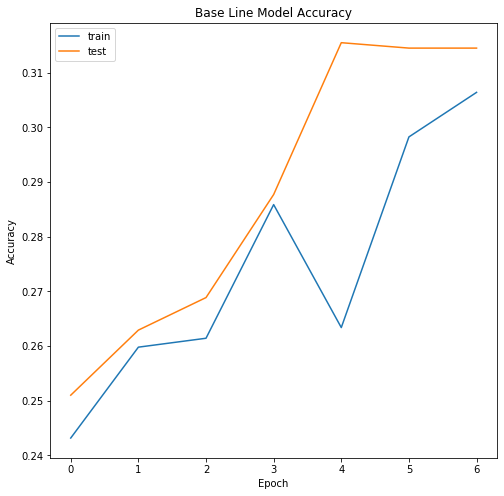

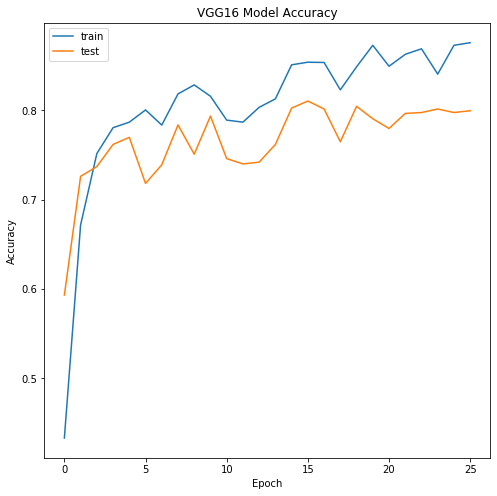

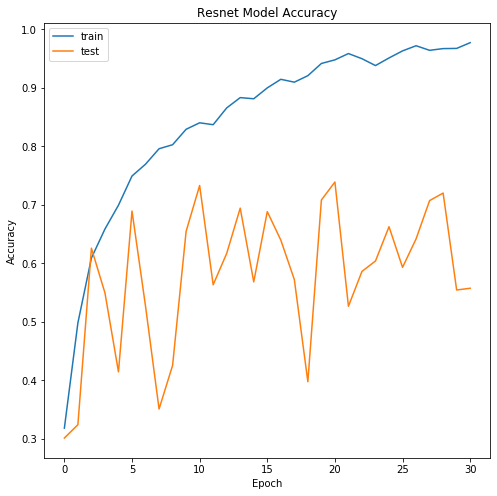

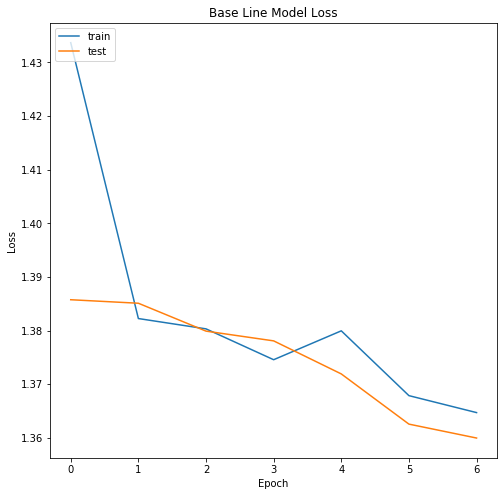

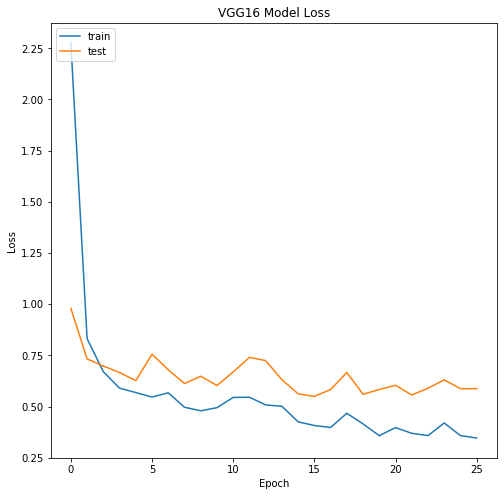

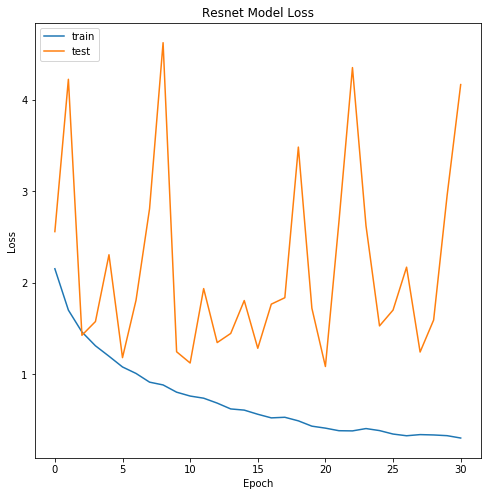

Evaluate Model 611.7909803390503 seconds


In [11]:
watch_restart()

# ===== 7. Evaluate Models

def print_score(title, model, X_test, y_test, label_class):
    scores = model.evaluate(X_test, y_test, verbose=1)
    print("{0} {1} {2}".format(title, model.metrics_names[1], scores[1]*100))
    y_pred = model.predict(X_test)
    print('\n', classification_report(np.where(y_test > 0)[1], 
                                      np.argmax(y_pred, axis=1), 
                                      target_names=list(label_class.keys())), sep='')

def plot_accuracy(title, history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['acc'])     # Training Accuracy
    plt.plot(history.history['val_acc']) # Validation Accuracy
    plt.title('{0} Model Accuracy'.format(title))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_loss(title, history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['loss'])     # Training Loss
    plt.plot(history.history['val_loss']) # Validation Loss
    plt.title('{0} Model Loss'.format(title))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# Scores
print_score('Base Line', model_base, X_test, y_test, LABEL_CLASS)
print_score('VGG16', model_vgg16, X_test, y_test, LABEL_CLASS)
print_score('Resnet', model_resnet, X_test, y_test, LABEL_CLASS)

# Plot Accuracy 
plot_accuracy('Base Line', history_base)
plot_accuracy('VGG16', history_vgg16)
plot_accuracy('Resnet', history_resnet)

# Plot Model Loss
plot_loss('Base Line', history_base)
plot_loss('VGG16', history_vgg16)
plot_loss('Resnet', history_resnet)

watch_print('Evaluate Model')